# Go through all steps of building an AMN model

With *in silico* datasets generated with the E. coli core model.

# Install conda on your Colab environment

Ignore this first cell if you are running the notebook in a local environment.

One can still run it locally but it will have no effect.

In [1]:
# Run this cell first - it will install a conda distribution (mamba)
# on your Drive then restart the kernel automatically 
# (don't worry about the crashing/restarting kernel messages)
# It HAS to be runned FIRST everytime you use the notebook in colab
import tensorflow as tf
import os
import sys
RunningInCOLAB  = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

# Set up your Colab or local environment

Run this cell in both cases of use (local or Colab)

In [2]:
import os
import sys
RunningInCOLAB  = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    
    # Check everything is fine with conda in Colab
    import condacolab
    condacolab.check()
    
    # Mount your drive environment in the colab runtime
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    
    # Change this variable to your path on Google Drive to which the repo has been cloned
    # If you followed the colab notebook 'repo_cloning.ipynb', nothing to change here
    repo_path_in_drive = '/content/drive/My Drive/Github/amn_release/'
    # Change directory to your repo cloned in your drive
    DIRECTORY = repo_path_in_drive
    os.chdir(repo_path_in_drive)
    # Copy the environment given in the environment_amn_light.yml
    !mamba env update -n base -f environment_amn_light.yml
    
    # This is one of the few Colab-compatible font
    font = 'Liberation Sans'
    
else:
    
    # In this case the local root of the repo is our working directory
    DIRECTORY = './'
    font = 'arial'

# printing the working directory files. One can check you see the same folders and files as in the git webpage.
print(os.listdir(DIRECTORY))

# We declare this function here and not in the
# function-storing python file to modify it easily
# as it can change the printouts of the methods
def printout(V, Stats, model): 
    # printing Stats
    print("R2 = %.2f (+/- %.2f) Constraint = %.2f (+/- %.2f)" % \
          (Stats.train_objective[0], Stats.train_objective[1],
           Stats.train_loss[0], Stats.train_loss[1]))
    Vout = tf.convert_to_tensor(np.float32(model.Y))
    Loss_norm, dLoss = Loss_Vout(V, model.Pout, Vout)
    print('Loss Targets', np.mean(Loss_norm))
    Loss_norm, dLoss = Loss_SV(V, model.S)
    print('Loss SV', np.mean(Loss_norm))
    Vin = tf.convert_to_tensor(np.float32(model.X))
    Pin = tf.convert_to_tensor(np.float32(model.Pin))
    if Vin.shape[1] == model.S.shape[1]: # special case
        Vin  = tf.linalg.matmul(Vin, tf.transpose(Pin), b_is_sparse=True)
    Loss_norm, dLoss = Loss_Vin(V, model.Pin, Vin, model.mediumbound, None)
    print('Loss Vin bound', np.mean(Loss_norm))
    Loss_norm, dLoss = Loss_Vpos(V, model)
    print('Loss V positive', np.mean(Loss_norm))

['.env', '.git', '.gitignore', '.ipynb_checkpoints', 'Build_Dataset.ipynb', 'Build_Dataset_KO.ipynb', 'Build_Experimental.ipynb', 'Build_Model_AMN.ipynb', 'Build_Model_AMN_KO.ipynb', 'Build_Model_ANN_Dense.ipynb', 'Build_Model_MM.ipynb', 'Build_Model_RC.ipynb', 'Dataset_experimental', 'Dataset_input', 'Dataset_model', 'Duplicate_Model.ipynb', 'environment_amn.yml', 'environment_amn_light.yml', 'Figures', 'Figures.ipynb', 'Library', 'LICENSE', 'README.md', 'Reservoir', 'Result', 'Tutorial.ipynb']


# 1° Duplicate reactions of the E. coli core model

The goal is to obtain a positive flux only model, to be then used for neural computations 

To perform this step, refer to the notebook `Duplicate_Model.ipynb`. In this tutorial we will use the output of this notebook, i.e. the duplicated-reactions model of E. coli core. It is already present in the git, no need to run the notebook again.

# 2° Generate a training set by running cobrapy with different inputs

Import required functions

In [3]:
from Library.Build_Dataset import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Set the parameters for your training set generation.

We call a 'medium file', containing information on which exchange reaction to consider, in which range to draw random values for these, and at which ratio the exchange reactions are turned on. This file is in the folder `Dataset_model/`, one can access and modify it for generating other training sets. 

In [4]:
# Generate training set with E coli core model with pFBA simulation

# What you can change
seed = 10
np.random.seed(seed=seed)  # seed for random number generator
cobraname =  'e_coli_core_duplicated'  # name of the model, stored in Dataset_model/ with .xml suffix
mediumname = 'e_coli_core' # name of the medium file, stored in Dataset_model/ with .csv suffix
mediumbound = 'UB' # Exact bound (EB) or upper bound (UB)
method = 'pFBA' # FBA, pFBA or EXP
size  = 50 # training set size
reduce = False # Set at True if you want to reduce the model
# End of What you can change

Run cobra with specified parameters and 'medium file'.

Then save the training set and test the loading to verify it is well built and accessible.

In [5]:
# Run cobra
cobrafile  = DIRECTORY+'Dataset_input/'+cobraname
mediumfile = DIRECTORY+'Dataset_input/'+mediumname
parameter = TrainingSet(cobraname=cobrafile, 
                        mediumname=mediumfile, mediumbound=mediumbound, 
                        method=method,objective=[],
                        measure=[])
parameter.get(sample_size=size)

# Saving file
trainingfile  = DIRECTORY+'Dataset_model/'+mediumname+'_'+parameter.mediumbound+'_'+str(size)
parameter.save(trainingfile, reduce=reduce)

# Verifying
parameter = TrainingSet()
parameter.load(trainingfile)
parameter.printout()

model file name: ./Dataset_model/e_coli_core_UB_50
reduced model: False
medium file name: ./Dataset_input/e_coli_core
medium bound: UB
list of reactions in objective: ['BIOMASS_Ecoli_core_w_GAM']
method: pFBA
trainingsize: 50
list of medium reactions: 20
list of medium levels: 20
list of medium values: 20
ratio of variable medium turned on: 0.5
list of measured reactions: 154
Stoichiometric matrix (72, 154)
Boundary matrix from reactions to medium: (20, 154)
Measurement matrix from reaction to measures: (154, 154)
Reaction to metabolite matrix: (72, 154)
Metabolite to reaction matrix: (154, 72)
Training set X: (50, 20)
Training set Y: (50, 154)
S_int matrix (67, 154)
S_ext matrix (154, 298)
Q matrix (154, 67)
P matrix (154, 154)
b_int vector (67,)
b_ext vector (50, 298)
Sb matrix (154, 72)
c vector (154,)


In [6]:
# The object 'parameter' has many attributes, listed here below
dir(parameter)
# This object is created when generating a training set and loaded when training a model on that training set.

['M2V',
 'P',
 'Pin',
 'Pout',
 'Q',
 'S',
 'S_ext',
 'S_int',
 'Sb',
 'V2M',
 'X',
 'Y',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'allmatrices',
 'b_ext',
 'b_int',
 'c',
 'cobraname',
 'filter_measure',
 'get',
 'levmed',
 'load',
 'measure',
 'medium',
 'mediumbound',
 'mediumname',
 'method',
 'model',
 'objective',
 'printout',
 'ratmed',
 'reduce',
 'reduce_and_run',
 'save',
 'size',
 'valmed']

We can plot a heatmap of the generated training set. First, the X values (i.e. the exchange reactions upper bounds) and then the Y values (i.e. the whole flux distribution solved by cobrapy with pFBA).

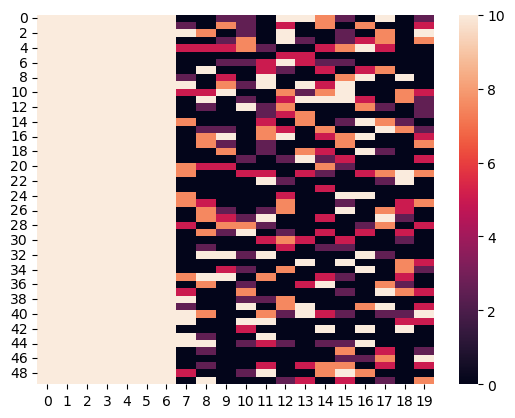

In [7]:
sns.heatmap(pd.DataFrame(parameter.X))
plt.show()

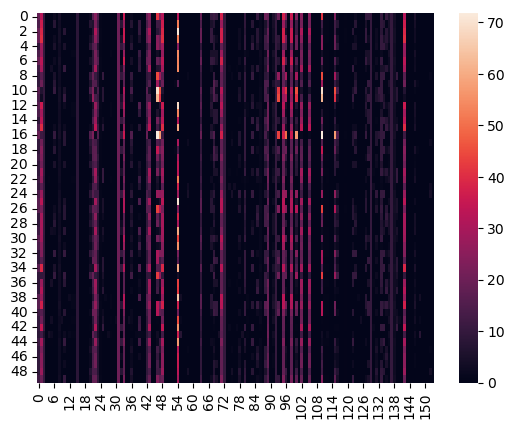

In [8]:
sns.heatmap(pd.DataFrame(parameter.Y))
plt.show()

# 3° Build different kind of models: mechanistic, neural or hybrid

## 3.1° Mechanistic model: AMN-suitable mechanistic methods alone

This step aims to check if in-house AMN-suitable mechanistic methods reach satisfactory solutions, i.e. solutions that have the same value for the objective reaction set for generating the training set (here, the default objective `BIOMASS_Ecoli_core_w_GAM`), and if the constraints of the metabolic network are well respected: SV=0, V>0, exchange reactions bounds (Vin) respected.

NB: no learning is performed here. We solve each element of the training set independently from each other, with the in-house solvers QP or LP.

Import required functions

In [9]:
from Library.Build_Model import *

Set the parameters for your mechanistic methods.

In [10]:
# Run Mechanistic model (no training) QP (quadratic program) or LP (linear program)
# using E. coli core simulation training sets and EB (or UB) bounds

# What you can change
seed = 10
np.random.seed(seed=seed)  
trainname = 'e_coli_core_UB_50' # the training set file name (generated at previous step)
size = 5 # number of runs must be lower than the number of element in trainname
timestep = int(1.0e4) # LP 1.0e4 QP 1.0e5
learn_rate = 0.3 # for LP: 0.3; for QP: 1.0
decay_rate = 0.9 # only in QP, 0.9
solver = 'MM_LP' # choose between MM_LP or MM_QP
# End of What you can change

# Create model and run GD for X and Y randomly drawn from trainingfile
trainingfile = DIRECTORY+'Dataset_model/'+trainname
model = Neural_Model(trainingfile = trainingfile, 
              objective=['BIOMASS_Ecoli_core_w_GAM'], 
              model_type = solver, 
              timestep = timestep, 
              learn_rate = learn_rate, 
              decay_rate = decay_rate)
# Prints a summary of the model before running

model.printout()

training file: ./Dataset_model/e_coli_core_UB_50
model type: MM_LP
model scaler: 0.0
model input dim: 20
model output dim: 1
model medium bound: UB
timestep: 10000
training set size (50, 20) (50, 1)


In [11]:
# Runs the appropriate method

if model.model_type is 'MM_QP':
    Ypred, Stats = MM_QP(model, verbose=True)
if model.model_type is 'MM_LP':
    Ypred, Stats = MM_LP(model, verbose=True)

# Printing results
printout(Ypred, Stats, model)

LP-Loss 1 0.22319156 0.056573782
LP-Loss 10 0.20051904 0.056685932
LP-Loss 100 0.06593693 0.03126802
LP-Loss 1000 0.00020193863 0.00027553746
LP-Loss 2000 2.8318558e-05 3.9391765e-05
LP-Loss 3000 1.0665195e-05 1.9738338e-05
LP-Loss 4000 4.465469e-06 1.23543905e-05
LP-Loss 5000 2.8441523e-06 1.0824397e-05
LP-Loss 6000 2.2587838e-06 9.0682315e-06
LP-Loss 7000 1.8381434e-06 7.661195e-06
LP-Loss 8000 1.4816027e-06 6.360967e-06
LP-Loss 9000 1.1947708e-06 5.2122064e-06
LP-Loss 10000 9.493007e-07 4.226714e-06
AMN output shapes for PoutV, SV, PinV, Vpos, V, outputs (50, 1) (50, 1) (50, 1) (50, 1) (50, 154) (50, 312)
R2 = 1.00 (+/- 0.00) Constraint = 0.00 (+/- 0.00)
Loss Targets 0.00052019715
Loss SV 6.518358e-07
Loss Vin bound 5.2770887e-05
Loss V positive 1.1896882e-05


## 3.2° Neural: classical Artificial Neural Networks (ANN)

This step aims to use classical neural networks for learning on the cobrapy-generated dataset, looking at the performance of a pure black-box without any computation using the stoichiometric matrix of the network or other 'knowledge'.

We use a 5-fold cross-validation scheme on 90% of the data and an independent test-set of 10% of the data.

Import required functions

In [12]:
from Library.Build_Model import *
# We declare this function here and not in the
# function-storing python file to modify it easily
# as it can change the printouts of the methods
def printout(filename, Stats, model, time): 
    # printing Stats
    print('Stats for %s CPU-time %.4f' % (filename, time))
    print('R2 = %.4f (+/- %.4f) Constraint = %.4f (+/- %.4f)' % \
          (Stats.train_objective[0], Stats.train_objective[1],
           Stats.train_loss[0], Stats.train_loss[1]))
    print('Q2 = %.4f (+/- %.4f) Constraint = %.4f (+/- %.4f)' % \
          (Stats.test_objective[0], Stats.test_objective[1],
           Stats.test_loss[0], Stats.test_loss[1]))

In [13]:
# Create, train and evaluate ANN model with FBA simulated training set for E. coli core

# What you can change 
seed = 10
ratio_test = 0.1 # part of the training set removed for test
np.random.seed(seed=seed)  
trainname = 'e_coli_core_UB_50'
# End of What you can change

# Create model
trainingfile = DIRECTORY+'Dataset_model/'+trainname
model = Neural_Model(trainingfile = trainingfile, 
              objective=['BIOMASS_Ecoli_core_w_GAM'], 
              model_type = 'ANN_Dense',
              n_hidden = 1, hidden_dim = 50, 
              epochs = 500, xfold = 5)
ID = np.random.choice(model.X.shape[0], 
                      size=int(model.X.shape[0]*ratio_test), replace=False)
Xtest,  Ytest  = model.X[ID,:], model.Y[ID,:]
Xtrain, Ytrain = np.delete(model.X, ID, axis=0), np.delete(model.Y, ID, axis=0) 
model.printout()

# Train and evaluate
reservoirname = trainname +'_'+model.model_type
reservoirfile = DIRECTORY+'Reservoir/'+reservoirname
start_time = time.time()
model.X, model.Y = Xtrain, Ytrain
reservoir, pred, stats, _ = train_evaluate_model(model, verbose=False)
delta_time = time.time() - start_time

# Printing cross-validation results
printout(reservoirname, stats, model, delta_time)

# Save, reload and run idependent test set
reservoir.save(reservoirfile)
reservoir.load(reservoirfile)
reservoir.printout()
if len(Xtest) > 0:
    start_time = time.time()
    reservoir.X, reservoir.Y = Xtest, Ytest
    X, Y = model_input(reservoir,verbose=False)
    pred, stats = evaluate_model(reservoir.model, X, Y, reservoir, verbose=False)
    delta_time = time.time() - start_time
    printout('Test set', stats, model, delta_time)

training file: ./Dataset_model/e_coli_core_UB_50
model type: ANN_Dense
model scaler: 0.0
model input dim: 20
model output dim: 1
model medium bound: UB
timestep: 0
training set size (50, 20) (50, 1)
nbr hidden layer: 1
hidden layer size: 50
activation function: relu
training epochs: 500
training regression: True
training learn rate: 0.001
training dropout: 0.25
training batch size: 5
training validation iter: 0
training xfold: 5
training early stopping: False
nbr parameters: 1101
---------- 1
---------- 1
train = 0.95 test = 0.95 loss-train = -1.000000 loss-test = -1.000000 iter=0
nbr parameters: 1101
---------- 1
---------- 1
train = 0.98 test = 0.93 loss-train = -1.000000 loss-test = -1.000000 iter=0
nbr parameters: 1101
---------- 1
---------- 1
train = 0.99 test = 0.96 loss-train = -1.000000 loss-test = -1.000000 iter=0
nbr parameters: 1101
---------- 1
---------- 1
train = 0.95 test = 0.88 loss-train = -1.000000 loss-test = -1.000000 iter=0
nbr parameters: 1101
---------- 1
------

NB: a Constraint=-1.00 is expected with such black box architecture, it is the default value when no constraint is computed. 

With the given parameters we should obtain Q2=0.68 on the test set.

## 3.3° Hybrid: Artificial Metabolic Network (AMN) architecture

This step aims to use an AMN architecture for learning on the cobrapy-generated dataset, looking at the performance of a hybrid model with computations using the stoichiometric matrix of the network and other 'knowledge'.

We use a 5-fold cross-validation scheme on 90% of the data and an independent test-set of 10% of the data.

Import required functions

In [14]:
from Library.Build_Model import *

# We declare this function here and not in the
# function-storing python file to modify it easily
# as it can change the printouts of the methods
def printout(filename, Stats, model, time): 
    # printing Stats
    print('Stats for %s CPU-time %.4f' % (filename, time))
    print('R2 = %.4f (+/- %.4f) Constraint = %.4f (+/- %.4f)' % \
          (Stats.train_objective[0], Stats.train_objective[1],
           Stats.train_loss[0], Stats.train_loss[1]))
    print('Q2 = %.4f (+/- %.4f) Constraint = %.4f (+/- %.4f)' % \
          (Stats.test_objective[0], Stats.test_objective[1],
           Stats.test_loss[0], Stats.test_loss[1]))

In [15]:
# Create, train and evaluate AMN_QP o models with FBA simulated training set for E. coli core
# with EB or UB with a mechanistic layer

# What you can change 
seed = 10
ratio_test = 0.1 # part of the training set removed for test
np.random.seed(seed=seed)  
trainname = 'e_coli_core_UB_50' # can change EB by UB
timestep = 4
# End of What you can change
  
# Create model 90% for training 10% for testing
trainingfile = DIRECTORY+'Dataset_model/'+trainname
model = Neural_Model(trainingfile = trainingfile, 
                     objective=['BIOMASS_Ecoli_core_w_GAM'],  
                     model_type='AMN_QP', 
                     timestep = timestep, learn_rate=0.01,
                     scaler=True,
                     n_hidden = 1, hidden_dim = 50,
                     epochs=500, xfold=5,
                     verbose=True)
ID = np.random.choice(model.X.shape[0], 
                      size=int(model.X.shape[0]*ratio_test), replace=False)
Xtest,  Ytest  = model.X[ID,:], model.Y[ID,:]
Xtrain, Ytrain = np.delete(model.X, ID, axis=0), np.delete(model.Y, ID, axis=0)
model.printout()

# Train and evaluate
reservoirname = trainname+'_'+model.model_type
reservoirfile = DIRECTORY+'Reservoir/'+reservoirname
start_time = time.time()
model.X, model.Y = Xtrain, Ytrain
reservoir, pred, stats, _ = train_evaluate_model(model, verbose=False)
delta_time = time.time() - start_time

# Printing cross-validation results
printout(reservoirname, stats, model, delta_time)

# Save, reload and run idependent test set
reservoir.save(reservoirfile)
reservoir.load(reservoirfile)
reservoir.printout()
if len(Xtest) > 0:
    start_time = time.time()
    reservoir.X, reservoir.Y = Xtest, Ytest
    X, Y = model_input(reservoir, verbose=False)
    pred, stats = evaluate_model(reservoir.model, X, Y, reservoir, verbose=False)
    delta_time = time.time() - start_time
    printout('Test set', stats, model, delta_time)

number of reactions:  154 154
number of metabolites:  72
filtered measurements size:  1
training file: ./Dataset_model/e_coli_core_UB_50
model type: AMN_QP
model scaler: 1.0
model input dim: 20
model output dim: 1
model medium bound: UB
timestep: 4
training set size (50, 20) (50, 1)
nbr hidden layer: 1
hidden layer size: 50
activation function: relu
gradient learn rate: 0.01
gradient decay rate: 0.9
training epochs: 500
training regression: True
training learn rate: 0.001
training dropout: 0.25
training batch size: 5
training validation iter: 0
training xfold: 5
training early stopping: False
nbr parameters: 8904
---------- 1
---------- 1
train = 0.84 test = 0.90 loss-train = 0.003744 loss-test = 0.003506 iter=0
nbr parameters: 8904
---------- 1
---------- 1
train = 0.93 test = 0.88 loss-train = 0.002215 loss-test = 0.002056 iter=0
nbr parameters: 8904
---------- 1
---------- 1
train = 0.95 test = 0.93 loss-train = 0.003088 loss-test = 0.003939 iter=0
nbr parameters: 8904
---------- 1


With the given parameters the AMN should outperform the ANN and get to 0.93 of Q2. Moreover, it should comply with the constraints of the metabolic network, obtaining an aggregated constraint (see research paper or source code) of roughly 0.001.